# PUI 2018 Final Exam, by Pablo Mandiola (pmb434)

## Motivation

There is a known connection between school performance and the environment that a child is exposed to, including environmental conditions that may affect health, exposure to violence which affects stress level, and socioeconomic features, including income, which may determine the ability of a student to get help. Nonetheless, the modeling of school performance is difficult, as measures of performance may be biased and environmental features hard to measure.

In spite of that, I would like you to try and model performance, measures through the SAT score, of NYC students as a function of exposure to crime, measured through reports of crimes in school, living conditions, measured through the incidence of respiratory and drug related issues in the area, and optionally income.

**Imports:**

In [1]:
from __future__ import print_function
__author__= 'Pablo Mandiola'

#Data downloading/extracting
import os
from subprocess import Popen, PIPE
import requests
from zipfile import ZipFile

#Data handling
import numpy as np
import pandas as pd

#Spatial data handling
import geopandas as gpd
import shapely
from fiona.crs import from_epsg

#For Carto Query
try:
    import urllib2 as ulib
except ImportError:
    import urllib as ulib

try:
    from StringIO import BytesIO as io
except ImportError:
    from io import BytesIO as io

try:
    from urllib import urlencode as urlencode
except ImportError:
    from urllib.parse import urlencode as urlencode
    
try:
    from urllib import urlopen as urlopen
except ImportError:
    from urllib.request import urlopen as urlopen
    
try:
    from urllib2 import HTTPError as HTTPError
except ImportError:
    from urllib.error import HTTPError as HTTPError
    
#For ACS data
try:
    import StringIO as stringIO
except ImportError:
    import io  as stringIO

#For plotting
import matplotlib.pylab as pl
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='deep', font='DejaVu Sans', font_scale=1.2, rc=None)
%pylab inline

#For modeling
import sklearn.preprocessing as preprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble  import RandomForestRegressor
from sklearn.cross_validation import train_test_split

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Populating the interactive namespace from numpy and matplotlib


**Getting PUIDATA folder location:**

In [2]:
puidata = os.getenv("PUIDATA")
if puidata is None:
    os.environ["PUIDATA"] = "{}/data/PUIdata".format(os.getenv("HOME"))
    puidata = os.getenv("PUIDATA")
    print("Warning: PUIDATA environmental variable not found and set by code, please review!")
print("PUIDATA: {}".format(puidata))

PUIDATA: /nfshome/pmb434/PUIdata


**Getting Census API Key:**

In [3]:
#Set the folder for APIKEY.py file (CHANKE TO YOUR OWN)
%cd "../"

#Load API Keys
from APIKEY import CensusKey

#Go back to previuos folder
%cd -

/nfshome/pmb434
/nfshome/pmb434/PUI Final


**Function definitions:**

In [4]:
#Generic downloader
def download_file(url, filename, destiny='.', encoding='utf-8'):
    '''downloads a file and extracts it if needed
    url: the url of the file (string)
    filename: the filename (string)
    destiny: path where to download the file (string)
    encoding: encoding to use when extracting, defaults to utf-8 (string)
    
    returns list with paths of each downloaded/extracted file
    '''
    
    #Check if file exists, download if not
    if not os.path.isfile(destiny + '/' + filename):
        print ("Downloading file.")
        #Download with redirect
        resp = requests.request('GET', url, allow_redirects=True)
        with open(filename, 'wb') as f:
            f.write(resp.content)
        os.system("mv " + filename + " " + destiny)
    else:
        print("File already downloaded.")
    
    #Placeholder for files from container
    files = None
    
    #Get extension   
    file_ext = filename.split('.')[1]
    if file_ext == 'rar':
        
        #Get files from container
        files = Popen("unrar lb " + destiny + "/" + filename, shell=True, stdout=PIPE).stdout.read()
        files = files.decode(encoding).split(sep='\n')[:-1]
        files = [destiny + "/" + f.strip() for f in files]
        
        #Extract if needed
        missing = [f for f in files if not (os.path.isfile(f) or os.path.isdir(f))]
        if missing:
            print ("Extracting .{} container.".format(file_ext))
            os.system("unrar x " + destiny + "/" + filename + " " + destiny)
        else:
            print("File already extracted.")
            
    elif file_ext == 'zip' or file_ext == 'gz':
        
        #Get files from container
        files = Popen("unzip -Z1 " + destiny + "/" + filename, shell=True, stdout=PIPE).stdout.read()
        files = files.decode(encoding).split(sep='\n')[:-1]
        files = [destiny + "/" + f.strip() for f in files]
        
        #Extract if needed
        missing = [f for f in files if not os.path.isfile(f)]
        if missing:
            print ("Extracting .{} container.".format(file_ext))
            
            ZipFile(destiny + "/" + filename).extractall(destiny)
            #os.system("unzip " + destiny + "/" + filename + " -d " + destiny)
        else:
            print("File already extracted.")
            
    else:
        print("Won't extract {} file".format(file_ext))
    
    #Check again and return file path(s)
    if files is None:
        # Check:
        if not os.path.isfile(destiny + "/" + filename):
            print ("WARNING! Something is wrong: the file is not there.")
        else:
            print ("Files in place, you can continue.")
        
        return([destiny + "/" + filename])
    else:
        #Check:
        missing = [f for f in files if not (os.path.isfile(f) or os.path.isdir(f))]
        if missing:
            print ("WARNING! Something is wrong: some files are not there.")
            print (missing)
        else:
            print ("Files in place, you can continue.")
            
        return (files)

#Function to evaluate Null Hypothesis
def evalNullHypothesis(p, statistic, test, hypothesis=None,alpha=0.05):
    '''evaluates a null hypothesis using
    p: p-value of the test (numeric)
    statistic: value of the statistic (numeric)
    test: name of the statistical test performed (string)
    hypothesis: formulation of the null hypothesis that was tested (string)
    alpha: significance level for the test, defaults to 0.05 (numeric)
    '''
    
    if hypothesis:
        print ("The Null Hypothesis that {}".format(hypothesis))
    else:
        print ("The Null Hypothesis")
    if p < alpha :
        print ("can be rejected at alpha = {}".format(alpha))
    else: 
        print ("cannot be rejected (p<0.05)")
    print ("with a {} statistics of {:.2f} and a p-value of {}".format(test, statistic, p))

#Plot feature importance from RF
def featureImportancePlot(rf, labels):
    '''plots feature importance for random forest
    rf: the random forest model fit to the data
    labels: the names of the features
    '''
    
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)


    pl.figure()
    pl.title("Feature importances")
    pl.bar(range(indices.shape[0]), rf.feature_importances_[indices],
       color="SteelBlue", yerr=std[indices], align="center")
    pl.xticks(range(indices.shape[0]), np.array(labels)[indices], rotation=90)
    pl.xlim([-1, indices.shape[0]])
    pl.grid('off')
    pl.show()

def queryCartoDB(query, source, formatting = 'CSV'):
    '''queries carto datasets from a given carto account
    Arguments: 
    query - string: a valid sql query string
    format - outlut format  OPTIONAL (default CSV)
    source - a valid sql api endpoint OPTIONAL (default carto fb55 account)
    Returns:
    the return of the sql query AS A STRING
    NOTES:
    designed for the carto API, tested only with CSV return format'''
    
    
    data = urlencode({'format': formatting, 'q': query}).encode("utf-8")
    try:
        response = urlopen(source, data)
        return response.read()
    except HTTPError as e:
        raise (ValueError('\n'.join(ast.literal_eval(e.readline())['error'])))
        
def get_data(query, sql_source):
    '''submits a query to queryCartoDB and returns a pandas dataframe
    Arguments: 
    query - string: a valid sql query string
    source - a valid sql api endpoint OPTIONAL (e.g. fb55 account)
    '''
    try:
        return pd.read_csv(io(queryCartoDB(query, source=sql_source)), sep = ',')
    except ValueError as v:
        print (str(v))

## PART I: Data gathering and wrangling

### 1. Collect the school related data (10 points)
The dataset can be found on NYC open data. The dataset you should use is the 2012 SAT Results (depending on access method it could be caller 2012_SAT_Results)

#### 1.1 Collect School SAT data (5 points)
 - read in the SAT scores for NYC schools (3 points)
 - create a new feature: the average of all 3 SAT scores

In [5]:
#Download
nyc_sat_files = download_file(url = 'https://data.cityofnewyork.us/api/views/f9bf-2cp4/rows.csv?accessType=DOWNLOAD',
                                   filename = '2012_SAT_Results.csv',
                                   destiny = puidata)

#Load to pandas df
nyc_sat_df = pd.read_csv(nyc_sat_files[0])
nyc_sat_df.head()

File already downloaded.
Won't extract csv file
Files in place, you can continue.


,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


In [6]:
#Inspect variable types
nyc_sat_df.dtypes

DBN                                object
SCHOOL NAME                        object
Num of SAT Test Takers             object
SAT Critical Reading Avg. Score    object
SAT Math Avg. Score                object
SAT Writing Avg. Score             object
dtype: object

In [7]:
#Convert vars to numeric
nyc_sat_df['SAT Critical Reading Avg. Score'] = pd.to_numeric(nyc_sat_df['SAT Critical Reading Avg. Score'], errors='coerce')
nyc_sat_df['SAT Math Avg. Score'] = pd.to_numeric(nyc_sat_df['SAT Math Avg. Score'], errors='coerce')
nyc_sat_df['SAT Writing Avg. Score'] = pd.to_numeric(nyc_sat_df['SAT Writing Avg. Score'], errors='coerce')
nyc_sat_df['Num of SAT Test Takers'] = pd.to_numeric(nyc_sat_df['Num of SAT Test Takers'], errors='coerce')

#Calculate average SAT score
nyc_sat_df['SATall'] = (nyc_sat_df['SAT Critical Reading Avg. Score'] + \
                        nyc_sat_df['SAT Math Avg. Score'] + \
                        nyc_sat_df['SAT Writing Avg. Score'])/3

#Rename SAT Math column
nyc_sat_df.rename(columns={'SAT Math Avg. Score':'SATmath', 'Num of SAT Test Takers':'Nstudents'}, inplace=True)

#Keep only vars we need
nyc_sat_df = nyc_sat_df.loc[:,['DBN', 'Nstudents','SATmath', 'SATall']]
nyc_sat_df.head()

,DBN,Nstudents,SATmath,SATall
0,01M292,29.0,404.0,374.000000
1,01M448,91.0,423.0,390.666667
2,01M450,70.0,402.0,383.000000
3,01M458,7.0,401.0,391.333333
4,01M509,44.0,433.0,402.333333


In [8]:
#Check for missing data
nyc_sat_df.isnull().sum()

DBN           0
Nstudents    57
SATmath      57
SATall       57
dtype: int64

**Note:** We have 57 schools without SAT data in 2012

#### 1.2 Collect School Crime data (5 points)
This data collects crimes in schools from 2010 to 2016 on NYC open data.

The file is called School Safety Report

Number of crimes are reported by school and by crime category. This file contains location information (Lat/Lon for each school in the dataset) which will be the basis of your geospatial aggregations

* read in the NYPD crimes in school report
* inspect the distribution of crimes per school
* plot the distribution of "Average number of Major" crimes by school

You need to decide which variable should be used to identify the school. Since you will later merge this with the SAT scores it makes sense to use a variable that is in both datasets.

In [9]:
#Download
nyc_schoolcrime_files = download_file(url = 'https://data.cityofnewyork.us/api/views/qybk-bjjc/rows.csv?accessType=DOWNLOAD',
                                   filename = '2010_-_2016_School_Safety_Report.csv',
                                   destiny = puidata)

#Load to pandas df
nyc_schoolcrime_df = pd.read_csv(nyc_schoolcrime_files[0])

File already downloaded.
Won't extract csv file
Files in place, you can continue.


In [10]:
#Let's look at some useful columns
keep_columns = ['Building Code','Location Name', 'School Year', 'DBN','Major N','Oth N','NoCrim N','Prop N','Vio N','AvgOfMajor N','AvgOfOth N',\
                'AvgOfNoCrim N','AvgOfProp N','AvgOfVio N','Latitude','Longitude']

#inspect some schools
nyc_schoolcrime_df.loc[:, keep_columns].head()

,Building Code,Location Name,School Year,DBN,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude
0,K001,P.S. 001 The Bergen,2013-14,15K001,0.0,2.0,1.0,1.0,0.0,0.86,3.26,5.55,2.17,1.29,40.649042,-74.012289
1,K002,Parkside Preparatory Academy,2013-14,17K002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.656183,-73.951583
2,K002,P.S. K141,2013-14,75K141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.656183,-73.951583
3,K002,Explore Charter School,2013-14,84K704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.656183,-73.951583
4,K002,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,2013-14,NaN,1.0,5.0,2.0,2.0,4.0,0.52,1.71,2.49,1.16,0.75,40.656183,-73.951583


**Note:** As noted in the NYC Open Data dataset description, schools in the same building have the crime information at the consolidated building level. In the table above, rows 1,2,3 are in the same building and don't have crime information but row 4 represents the entire building and has the crime information for that specific location. I will use the building crime information for those schools, and I can do this with a backfill over columns after ordering the dataframe.

In [11]:
#Sort in a way that the building data comes right after its corresponding schools
nyc_schoolcrime_df.sort_values(['School Year','Building Code', 'DBN'], inplace=True)
nyc_schoolcrime_df.head(5)

,School Year,Building Code,DBN,Location Name,Location Code,Address,Borough,Geographical District Code,Register,Building Name,...,Borough Name,Postcode,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,2013-14,K001,15K001,P.S. 001 The Bergen,K001,309 47 STREET,K,15.0,"1,277",NaN,...,BROOKLYN,11220.0,40.649042,-74.012289,7.0,38.0,80.0,3011821.0,3.007550e+09,Sunset Park West ...
1,2013-14,K002,17K002,Parkside Preparatory Academy,K002,655 PARKSIDE AVENUE,K,17.0,479,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,...,BROOKLYN,11226.0,40.656183,-73.951583,9.0,40.0,802.0,3378201.0,3.050500e+09,Prospect Lefferts Gardens-Wingate ...
2,2013-14,K002,75K141,P.S. K141,K141,655 PARKSIDE AVENUE,K,17.0,397,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,...,BROOKLYN,11226.0,40.656183,-73.951583,9.0,40.0,802.0,3378201.0,3.050500e+09,Prospect Lefferts Gardens-Wingate ...
3,2013-14,K002,84K704,Explore Charter School,K704,655 PARKSIDE AVENUE,K,17.0,NaN,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,...,BROOKLYN,11226.0,40.656183,-73.951583,9.0,40.0,802.0,3378201.0,3.050500e+09,Prospect Lefferts Gardens-Wingate ...
4,2013-14,K002,NaN,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,NaN,655 PARKSIDE AVENUE,K,17.0,876,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,...,BROOKLYN,11226.0,40.656183,-73.951583,9.0,40.0,802.0,3378201.0,3.050500e+09,Prospect Lefferts Gardens-Wingate ...


In [12]:
#Only do the backfill it on the data columns to keep the building's DBN as Nan
crime_columns = ['Major N','Oth N','NoCrim N','Prop N','Vio N','AvgOfMajor N','AvgOfOth N',\
                'AvgOfNoCrim N','AvgOfProp N','AvgOfVio N']

nyc_schoolcrime_df.loc[:,crime_columns] = nyc_schoolcrime_df[crime_columns].fillna(method='backfill', axis=0)

#inspect same schools again
nyc_schoolcrime_df.loc[:, keep_columns].head(5)

,Building Code,Location Name,School Year,DBN,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude
0,K001,P.S. 001 The Bergen,2013-14,15K001,0.0,2.0,1.0,1.0,0.0,0.86,3.26,5.55,2.17,1.29,40.649042,-74.012289
1,K002,Parkside Preparatory Academy,2013-14,17K002,1.0,5.0,2.0,2.0,4.0,0.52,1.71,2.49,1.16,0.75,40.656183,-73.951583
2,K002,P.S. K141,2013-14,75K141,1.0,5.0,2.0,2.0,4.0,0.52,1.71,2.49,1.16,0.75,40.656183,-73.951583
3,K002,Explore Charter School,2013-14,84K704,1.0,5.0,2.0,2.0,4.0,0.52,1.71,2.49,1.16,0.75,40.656183,-73.951583
4,K002,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,2013-14,NaN,1.0,5.0,2.0,2.0,4.0,0.52,1.71,2.49,1.16,0.75,40.656183,-73.951583


In [13]:
nyc_schoolcrime_df[crime_columns].isnull().sum()

Major N          0
Oth N            0
NoCrim N         0
Prop N           0
Vio N            0
AvgOfMajor N     0
AvgOfOth N       0
AvgOfNoCrim N    0
AvgOfProp N      0
AvgOfVio N       0
dtype: int64

**Note:** Now we don;t have any missing crime data. Also, according to the dataset description there are some schools with multiple locations so I will merge by DBN + Location.

In [14]:
nyc_schoolcrime_df.shape

(6310, 34)

In [15]:
#Drop schools with no location data
nyc_schoolcrime_df.dropna(subset=['Latitude', 'Longitude'], inplace=True)

#Fill Nans in data columns with 0 
nyc_schoolcrime_df.fillna(0, inplace=True)

#Group by school and get the mean
#(This is also getting the mean for lat/long, but it is always the same for each school so it shouldn't matter)
nyc_schoolcrime_df = nyc_schoolcrime_df.groupby(['DBN', 'Latitude', 'Longitude'], as_index=False)[keep_columns[2:]].mean()
nyc_schoolcrime_df.head()

,DBN,Latitude,Longitude,AvgOfMajor N,AvgOfNoCrim N,AvgOfOth N,AvgOfProp N,AvgOfVio N,Major N,NoCrim N,Oth N,Prop N,Vio N
0,0,40.508809,-74.222403,0.460000,3.030000,1.876667,1.170000,0.880000,1.333333,34.333333,4.666667,0.666667,4.333333
1,0,40.528092,-74.192032,1.843333,12.576667,8.890000,6.400000,2.556667,0.666667,28.000000,14.333333,8.000000,5.000000
2,0,40.569393,-74.107737,3.133333,33.630000,12.443333,7.060000,5.863333,2.333333,34.666667,13.000000,7.666667,5.000000
3,0,40.577520,-73.969517,0.286667,1.393333,0.960000,0.680000,0.433333,0.000000,0.333333,0.000000,0.000000,0.000000
4,0,40.579737,-73.956329,0.796667,5.463333,3.166667,2.023333,1.490000,0.333333,2.666667,2.333333,1.333333,1.333333


In [16]:
nyc_schoolcrime_df.shape

(2308, 13)

In [17]:
#Lot's of records without DBN (These were the buildings, so I will drop them)
nyc_schoolcrime_df = nyc_schoolcrime_df.loc[nyc_schoolcrime_df.DBN != 0, :]
nyc_schoolcrime_df.shape

(1938, 13)

In [18]:
#Check for missing data
nyc_schoolcrime_df.isnull().sum()

DBN              0
Latitude         0
Longitude        0
AvgOfMajor N     0
AvgOfNoCrim N    0
AvgOfOth N       0
AvgOfProp N      0
AvgOfVio N       0
Major N          0
NoCrim N         0
Oth N            0
Prop N           0
Vio N            0
dtype: int64

In [19]:
#Data  dictionary from NYC Open Data
data_dictionary = {'Major N':'number of major crimes',
                   'Oth N':'number of other crimes',
                   'NoCrim N':'number of non-criminal crimes',
                   'Prop N':'number of property crimes',
                   'Vio N':'number of violent crimes',
                   'AvgOfMajor N':'avg of major crimes for buildings w/same population group and size',
                   'AvgOfOth N':'avg of other crimes for buildings w/same population group and size',
                   'AvgOfNoCrim N':'avg of non-criminal crimes for buildings w/same population group and size',
                   'AvgOfProp N':'avg of property crimes for buildings w/same population group and size',
                   'AvgOfVio N':'avg of violent crimes for buildings w/same population group and size'}

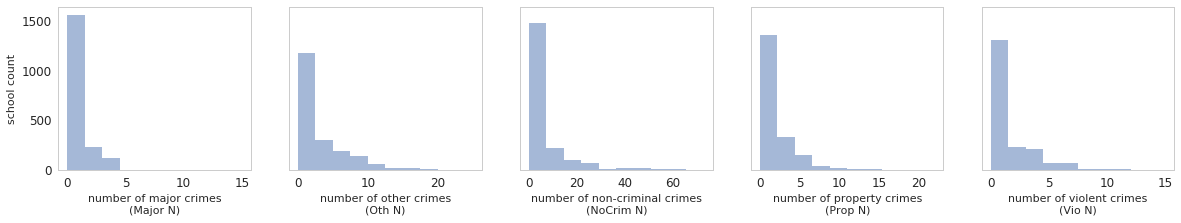

In [20]:
#Inspect the distribution of crimes
fig, axes = pl.subplots(nrows=1, ncols=5, figsize=(20,3), sharey=True)

for i, col in enumerate(crime_columns[:5]):
    (n, bins, patches) = axes[i].hist(nyc_schoolcrime_df[col], density=False, alpha=0.5)
    axes[i].set_xlabel('{}\n({})'.format(data_dictionary[col],col), fontsize=11)
    axes[i].grid(False)

axes[0].set_ylabel('school count', fontsize=11)
pl.show()

**Figure 1: Histograms of number of crimes per school by crime type.** The histograms show the distribution of the number of crimes. Most schools have close to zero reports of crimes for all types, so the distributions are skewed to the right and look like a Poisson distribution. The histogram at the center for non-criminal crimes is the one with the largest range, with a maximum of around 60 reported crimes.

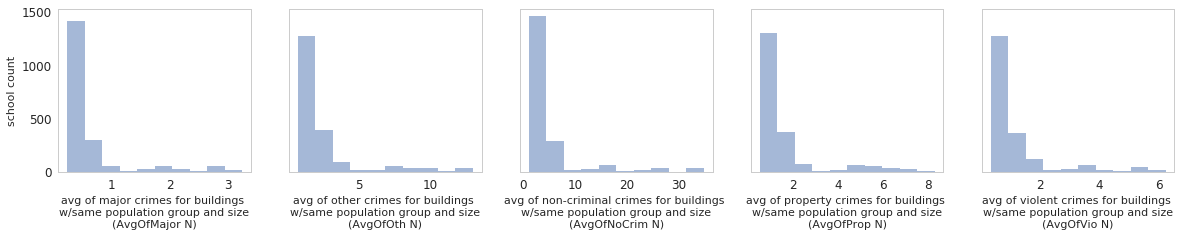

In [21]:
#Inspect the distribution of crimes, average indicators
fig, axes = pl.subplots(nrows=1, ncols=5, figsize=(20,3), sharey=True)

for i, col in enumerate(crime_columns[5:]):
    (n, bins, patches) = axes[i].hist(nyc_schoolcrime_df[col], density=False, alpha=0.5)
    axes[i].set_xlabel('{}\n({})'.format(data_dictionary[col].replace('w/','\nw/'),col), fontsize=11)
    axes[i].grid(False)

axes[0].set_ylabel('school count', fontsize=11)
pl.show()

**Figure 2: Histograms of the average number of crimes for all buildings with the same population group and size, per school by crime type.** After looking for the data dictionary in NYC Open Data, I realized that all the averaged indicators in the datasets are calculated over schools having the same population group and size as defined by DOE. The distributions look similar to the ones in Figure 1 but with more schools in the tails and a shorter range, because we are looking at averages.

### 2. Merge school crime and SAT data (10 points)
Identify a common column and merge based on that. mind that there may be duplicates! especially if you only save the relevant columns

#### 2.1 Merge the SAT and the crime in school data based on the school identifier. (4 points)

In [22]:
print("crime schools DF shape", nyc_schoolcrime_df.shape, "SAT schools DF shape", nyc_sat_df.shape)

crime schools DF shape (1938, 13) SAT schools DF shape (478, 4)


**Note:** Because we need the location from the crimes data and the SAT scores from the other dataset, we have to do an inner join.

In [23]:
#Merge by school's DBN
nyc_schools_df = pd.merge(nyc_schoolcrime_df, nyc_sat_df, on='DBN', how='inner')
nyc_schools_df.head()

,DBN,Latitude,Longitude,AvgOfMajor N,AvgOfNoCrim N,AvgOfOth N,AvgOfProp N,AvgOfVio N,Major N,NoCrim N,Oth N,Prop N,Vio N,Nstudents,SATmath,SATall
0,01M292,40.713684,-73.986336,0.496667,2.833333,1.813333,1.213333,0.890000,1.333333,5.333333,7.666667,6.000000,3.000000,29.0,404.0,374.000000
1,01M448,40.712399,-73.984497,0.296667,1.380000,1.023333,0.720000,0.473333,0.333333,3.000000,1.333333,0.666667,0.333333,91.0,423.0,390.666667
2,01M450,40.729589,-73.982555,0.306667,1.773333,1.183333,0.790000,0.543333,0.333333,0.666667,3.333333,2.000000,0.666667,70.0,402.0,383.000000
3,01M458,40.722520,-73.990728,0.296667,1.380000,1.023333,0.720000,0.473333,0.333333,1.666667,5.666667,3.666667,2.000000,7.0,401.0,391.333333
4,01M509,40.720581,-73.985645,0.536667,3.630000,2.236667,1.346667,1.033333,1.333333,11.000000,7.666667,3.666667,4.000000,44.0,433.0,402.333333


In [24]:
nyc_schools_df.shape

(463, 16)

In [25]:
nyc_schools_df[nyc_schools_df.DBN.duplicated(keep=False)]

,DBN,Latitude,Longitude,AvgOfMajor N,AvgOfNoCrim N,AvgOfOth N,AvgOfProp N,AvgOfVio N,Major N,NoCrim N,Oth N,Prop N,Vio N,Nstudents,SATmath,SATall
97,05M362,40.810431,-73.955809,0.506667,3.196667,1.836667,1.206667,0.853333,0.333333,0.666667,0.666667,1.000000,0.000000,NaN,NaN,NaN
98,05M362,40.810511,-73.955997,0.500000,3.550000,1.900000,1.230000,0.905000,0.500000,0.500000,1.000000,1.500000,0.000000,NaN,NaN,NaN
400,27Q475,40.693006,-73.829407,2.390000,13.670000,7.890000,5.220000,3.940000,4.000000,23.000000,13.000000,6.000000,7.000000,404.0,404.0,384.666667
401,27Q475,40.695888,-73.833681,1.750000,12.330000,6.376667,4.416667,2.943333,1.666667,26.333333,9.666667,4.666667,4.333333,404.0,404.0,384.666667


**Note:** There are some schools that were in the SAT dataset but not in the crime schools dataset. Also, for the two schools with more than one location we will have to treat them differently when aggregating. As I don't know how many students for those schools go in each location, I will assume they are divided evenly. One of them doesn't have SAT dat so we are going to get rid of it anyways later.

In [26]:
nyc_schools_df.loc[nyc_schools_df.DBN.duplicated(keep=False), 'Nstudents'] = nyc_schools_df.loc[nyc_schools_df.DBN.duplicated(keep=False), 'Nstudents']/2

In [27]:
nyc_schools_df[nyc_schools_df.DBN.duplicated(keep=False)]

,DBN,Latitude,Longitude,AvgOfMajor N,AvgOfNoCrim N,AvgOfOth N,AvgOfProp N,AvgOfVio N,Major N,NoCrim N,Oth N,Prop N,Vio N,Nstudents,SATmath,SATall
97,05M362,40.810431,-73.955809,0.506667,3.196667,1.836667,1.206667,0.853333,0.333333,0.666667,0.666667,1.000000,0.000000,NaN,NaN,NaN
98,05M362,40.810511,-73.955997,0.500000,3.550000,1.900000,1.230000,0.905000,0.500000,0.500000,1.000000,1.500000,0.000000,NaN,NaN,NaN
400,27Q475,40.693006,-73.829407,2.390000,13.670000,7.890000,5.220000,3.940000,4.000000,23.000000,13.000000,6.000000,7.000000,202.0,404.0,384.666667
401,27Q475,40.695888,-73.833681,1.750000,12.330000,6.376667,4.416667,2.943333,1.666667,26.333333,9.666667,4.666667,4.333333,202.0,404.0,384.666667


#### 2.2 Fill in the missing data as appropriate keeping in mind that the school with no crimes are not included i the crime-in-school database, so there you can assume that there were 0 crimes, but the missing SAT scores cannot be assumed to be 0 of course. hints (4 points)

In [28]:
#Check for missing data
nyc_schools_df.isnull().sum()

DBN               0
Latitude          0
Longitude         0
AvgOfMajor N      0
AvgOfNoCrim N     0
AvgOfOth N        0
AvgOfProp N       0
AvgOfVio N        0
Major N           0
NoCrim N          0
Oth N             0
Prop N            0
Vio N             0
Nstudents        51
SATmath          51
SATall           51
dtype: int64

**Note:** We can't assume the SAT score if the school is not in the data, so I will drop them. We will loose 51 schools.

In [29]:
nyc_schools_df.dropna(subset=['SATmath', 'SATall'], inplace=True)
nyc_schools_df.shape

(412, 16)

#### 2.3 Count the individual school location: there may be multiple schools in a single building. What could be the implication of this in your analysis? hints (2 points)

In [30]:
count_bylocation = nyc_schools_df.groupby(['Latitude', 'Longitude'], as_index=False)[['DBN']].count()
count_bylocation.head()

,Latitude,Longitude,DBN
0,40.528092,-74.192032,2
1,40.567873,-74.115373,1
2,40.569393,-74.107737,1
3,40.577208,-73.985953,1
4,40.580894,-73.935952,1


In [31]:
count_bylocation.DBN.value_counts()/count_bylocation.DBN.value_counts().sum()

1    0.717054
2    0.131783
3    0.062016
4    0.038760
5    0.027132
6    0.023256
Name: DBN, dtype: float64

**Note:** We can see that 29% of schools are located in buildings with multiple schools. As we saw before and because of the way I handled the data, this means that these schools will have the same crime reporting data but different SAT scores, which could impact our results since we are trying to build models based on the relation of these variables. However, as the models are built with the data averaged at the PUMA level the issue should dissapear: having multiple schools in a single location would be the same as having a single school in that location with the average from all schools located there. *For this we will need to use a weighted average by number of students when aggregating into PUMAs (which might be a good idea anyways)*

### 3. Visualize the school related data (10 points)
#### 3.1 plot the Math SAT score and the average of all SAT scores (the feature you created in Task 1) as a function of two crime statistics (5 points)
make sure your data is numeric, plot SAT Math score and the average SAT score (Math, reading, writing), each one against the

* number of major crimes and
* the average number of crimes

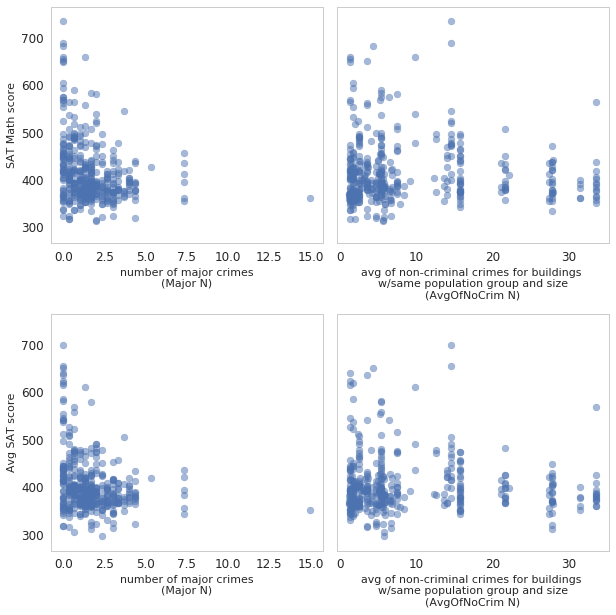

In [32]:
#Plot
fig, ((ax1, ax2), (ax3, ax4)) = pl.subplots(nrows=2, ncols=2, figsize=(10,10), sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0.05)

#SAT Math score
#Number of major crimes
ax1.set_ylabel('SAT Math score', fontsize=11)
ax1.set_xlabel('{}\n({})'.format(data_dictionary['Major N'].replace('w/','\nw/'),'Major N'), fontsize=11)

ax1.scatter(nyc_schools_df['Major N'], nyc_schools_df['SATmath'], alpha=0.5)
ax1.grid(False)

#Number of major crimes
#ax2.set_ylabel('SAT Math score', fontsize=11)
ax2.set_xlabel('{}\n({})'.format(data_dictionary['AvgOfNoCrim N'].replace('w/','\nw/'),'AvgOfNoCrim N'), fontsize=11)

ax2.scatter(nyc_schools_df['AvgOfNoCrim N'], nyc_schools_df['SATmath'], alpha=0.5)
ax2.grid(False)

#SAT average score
#Number of major crimes
ax3.set_ylabel('Avg SAT score', fontsize=11)
ax3.set_xlabel('{}\n({})'.format(data_dictionary['Major N'].replace('w/','\nw/'),'Major N'), fontsize=11)

ax3.scatter(nyc_schools_df['Major N'], nyc_schools_df['SATall'], alpha=0.5)
ax3.grid(False)

#Number of major crimes
#ax4.set_ylabel('Avg SAT score', fontsize=11)
ax4.set_xlabel('{}\n({})'.format(data_dictionary['AvgOfNoCrim N'].replace('w/','\nw/'),'AvgOfNoCrim N'), fontsize=11)

ax4.scatter(nyc_schools_df['AvgOfNoCrim N'], nyc_schools_df['SATall'], alpha=0.5)
ax4.grid(False)

pl.show()

**Figure 3: Math and Avg SAT score against two crimie statistics per school.** The similarity between the two scatter plots at the top (SAT math) and the two at the bottom (Avg SAT) indicate that these two variables might have a strong positive correlation. Also, we can see that the SAT scores have a slight negative corelation with these crime statistics, but most data points are concentrated close to zero in crime statistics with lots of variation in SAT scores there. 

#### 3.2 create geometry from the lat-lon coordinates and map the location of each school in the dataset (5 points)
hints, also reviewed in the final review

In [33]:
#Make a copy for the to be GeoDataFrame
nyc_schools_geo = nyc_schools_df.copy()

#Combine lat long into a tuple column
nyc_schools_geo['lonlat'] = list(zip(nyc_schools_geo.Longitude, nyc_schools_geo.Latitude))
#Create Point feature in geometry column
nyc_schools_geo['geometry'] = nyc_schools_geo.lonlat.apply(lambda x: shapely.geometry.Point(x))
#Create GeoDataFrame
nyc_schools_geo = gpd.GeoDataFrame(nyc_schools_geo)
#Set CRS
nyc_schools_geo.crs = from_epsg(4326)

In [34]:
#Download PUMA shapefile to improve map
nyc_puma_files = download_file(url = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile',
                                filename = 'NYC_PUMA_shapefile.zip',
                                destiny=puidata)

nyc_puma_geo = gpd.read_file(nyc_puma_files[1])
nyc_puma_geo.head()

File already downloaded.
File already extracted.
Files in place, you can continue.


,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


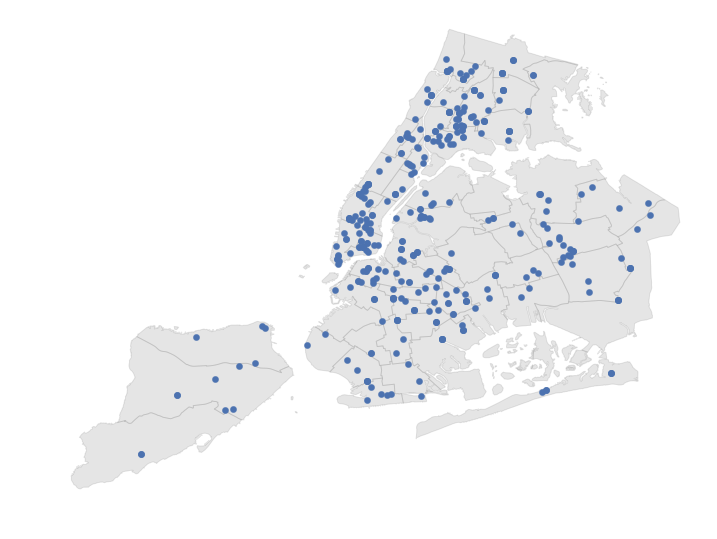

In [35]:
#Map
fig, ax = plt.subplots(figsize  = (12, 12))

ax.axis('off')
#leg = ax.get_legend()
#leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))

nyc_puma_geo.plot(ax=ax, edgecolor='grey', lw=1, color='grey', alpha=0.2)
nyc_schools_geo.plot(ax=ax, markersize=40)

#Correct aspect ratio
ax.axes.set_aspect('equal')

pl.show()

**Figure 4: Map of schools locations in NYC.** Only schools with SAT scores data for 2012 that are also found in the Safety Report 2010-2016 are shown. The geographical divisions correpond to PUMAs.

### 4 Gather Asthma and drugs hospital discharge (10 points)
Use the SPARCS dataset which contains de-identified hospitalization data for the state of NY in 2012. This file is available at https://healthdata.ny.gov/. This is a large file and it will be time consuming to read it online or download it. Reduce the data to only the 5 NYC boroughs hint

Note: As you do all this, keep track of how many facilities are lost at each step

#### 4.1 read in the SPARCS data (3 points)
* read in the SPARCS data
* throw away the data that is not in NYC

In [36]:
#Download
ny_sparcs_files = download_file(url = 'https://health.data.ny.gov/api/views/u4ud-w55t/rows.csv?accessType=DOWNLOAD',
                                filename = 'Hospital_Inpatient_Discharges__SPARCS_De-Identified___2012.csv',
                                destiny=puidata)

ny_sparcs_df = pd.read_csv(ny_sparcs_files[0])
ny_sparcs_df.head()

File already downloaded.
Won't extract csv file
Files in place, you can continue.


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Health Service Area,Hospital County,Operating Certificate Number,Facility ID,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,Payment Typology 2,Payment Typology 3,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
0,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,30 to 49,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,5511.95,5582.49
1,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,4783.20,5162.82
2,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,30 to 49,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,3829.15,4056.52
3,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,0 to 17,147,F,White,Not Span/Hispanic,...,NaN,NaN,182357.0,NaN,NaN,0,N,Y,1108.20,1644.75
4,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,3418.18,3370.87


In [37]:
#Keep only NYC data and columns we want
nyc_counties = ['Kings', 'Queens', 'Richmond', 'Manhattan', 'Bronx']
sparcs_columns = ['Facility ID', 'CCS Diagnosis Description']
nyc_sparcs_df = ny_sparcs_df.loc[ny_sparcs_df['Hospital County'].isin(nyc_counties),sparcs_columns]
nyc_sparcs_df.head()

,Facility ID,CCS Diagnosis Description
954417,1165.0,Asthma
954464,1165.0,Asthma
954762,1165.0,Asthma
954951,1165.0,Asthma
954967,1165.0,Nonspecific chest pain


In [38]:
nd = len(nyc_sparcs_df)
print("number of NYC discharges", nd)

number of NYC discharges 1199520


#### 4.2 calculate the fraction of asthma and drug related diagnoses per facility (3 points)
* count the number of asthma and drug related diagnoses per facility

Find in the file all asthma-related diagnosis : I used those that include asthma and respiratory issues as diagnosis that are relevant, and I used alcohol and drug related issues as well as poisoning from psychotropic substances as relevant drug-related diagnoses hint

* calculate the fraction of asthma/drug diagnoses over all diagnoses per facility

In [39]:
#Set the diagnosis description to use for each
asthma_diagnosis = ['Asthma', 'Respiratory failure; insufficiency; arrest (adult)',  'Respiratory distress syndrome']
drugs_diagnosis = ['Poisoning by psychotropic agents', 'Alcohol-related disorders', 'Substance-related disorders']

#Get indicator for each diagnosis
nyc_sparcs_df['asthma'] = nyc_sparcs_df['CCS Diagnosis Description'].isin(asthma_diagnosis).astype(int)
nyc_sparcs_df['drugs'] = nyc_sparcs_df['CCS Diagnosis Description'].isin(drugs_diagnosis).astype(int)

nyc_sparcs_df.head()

,Facility ID,CCS Diagnosis Description,asthma,drugs
954417,1165.0,Asthma,1,0
954464,1165.0,Asthma,1,0
954762,1165.0,Asthma,1,0
954951,1165.0,Asthma,1,0
954967,1165.0,Nonspecific chest pain,0,0


In [40]:
#Get counts
nyc_diagnosis_df = nyc_sparcs_df.groupby('Facility ID', as_index=False).agg({'CCS Diagnosis Description':'count',
                                                                          'asthma':'sum',
                                                                          'drugs':'sum'})
nyc_diagnosis_df.rename(columns={'CCS Diagnosis Description':'diagnosis_count',
                              'asthma':'asthma_count',
                              'drugs':'drugs_count'}, inplace=True)
nyc_diagnosis_df.head()

,Facility ID,asthma_count,diagnosis_count,drugs_count
0,1164.0,0,4917,2389
1,1165.0,1123,20956,1279
2,1168.0,580,15889,1006
3,1169.0,2105,43650,323
4,1172.0,1826,23142,611


In [41]:
nycF = len(nyc_diagnosis_df)
print("number of NYC facilities in the dataset", nycF)

number of NYC facilities in the dataset 61


In [42]:
nyca = nyc_diagnosis_df.asthma_count.sum()
print("number of asthma related cases in NYC", nyca) 

number of asthma related cases in NYC 30717


In [43]:
nycd = nyc_diagnosis_df.drugs_count.sum()
print("number of drug related cases in NYC", nycd)

number of drug related cases in NYC 46336


In [44]:
#Calculate ratios
nyc_diagnosis_df['asthma_ratio'] = nyc_diagnosis_df['asthma_count']/nyc_diagnosis_df['diagnosis_count']
nyc_diagnosis_df['drugs_ratio'] = nyc_diagnosis_df['drugs_count']/nyc_diagnosis_df['diagnosis_count']

#Keep only what we need
nyc_diagnosis_df = nyc_diagnosis_df.loc[:,['Facility ID', 'asthma_ratio', 'drugs_ratio']]

nyc_diagnosis_df.head(10)

,Facility ID,asthma_ratio,drugs_ratio
0,1164.0,0.000000,0.485865
1,1165.0,0.053588,0.061033
2,1168.0,0.036503,0.063314
3,1169.0,0.048225,0.007400
4,1172.0,0.078904,0.026402
5,1175.0,0.008216,0.000000
6,1176.0,0.044207,0.202915
7,1178.0,0.054454,0.013583
8,1185.0,0.057007,0.003671
9,1186.0,0.028288,0.019961


In [45]:
nyc_diagnosis_df.shape

(61, 3)

#### 4.3 find the location of each facility (4 points)
The facility coordinate information is on my Carto account and can be accessed with a SQL query (hint)

count and comment on the number of facilities left after the merge

The SQL source is "https://fb55.carto.com:443/api/v2/sql?q=" and the DB name is "nyc_facilities".

In [46]:
api_source = "https://fb55.carto.com:443/api/v2/sql?q="
query = '''SELECT * FROM fb55.nyc_facilities; '''
nyc_facilities_geo = get_data(query, api_source)
nyc_facilities_geo.head(5)

,the_geom,regional_office,the_geom_webmercator,facility_id,facility_name,short_description,description,facility_open_date,facility_address_1,facility_address_2,...,cooperator_name,cooperator_address,cooperator_address_2,cooperator_city,cooperator_state,cooperator_zip_code,ownership_type,facility_latitude,facility_longitude,facility_location
0,0101000020E6100000E40F069E7B7C52C05952EE3EC753...,Metropolitan Area Regional Office - New York City,0101000020110F000046B5633099665FC167AF70FB3AED...,1320,University Hospital of Brooklyn,HOSP,Hospital,01/01/1901,445 Lenox Road,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,State,40.654518,-73.945045,"(40.654518, -73.945045)"
1,0101000020E61000008BC058DFC07852C04BC8073D9B53...,Metropolitan Area Regional Office - New York City,0101000020110F00001F2C777543605FC14E668BB709ED...,6448,PALA Community Care,DTC,Diagnostic and Treatment Center,09/12/2002,1110 Pennsylvania Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,LLC,40.653175,-73.886772,"(40.653175, -73.886772)"
2,0101000020E6100000D3DC0A61357D52C09AFF571D3958...,Metropolitan Area Regional Office - New York City,0101000020110F00006ACD5FB9D4675FC19AEE7C2435F2...,6754,Medcare LLC,DTC,Diagnostic and Treatment Center,02/26/2007,468 Lafayette Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,LLC,40.689243,-73.956383,"(40.689243, -73.956383)"
3,0101000020E61000006DCA15DEE57952C08A027D224F6C...,Metropolitan Area Regional Office - New York City,0101000020110F00007164F52335625FC110A7A85CBB08...,1206,P R O M E S A Inc,DTC,Diagnostic and Treatment Center,09/27/1979,1776 Clay Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,Not for Profit Corporation,40.846165,-73.904655,"(40.846165, -73.904655)"
4,0101000020E6100000D6C4025FD17A52C038BF61A24168...,Metropolitan Area Regional Office - New York City,0101000020110F00006301C42AC5635FC1A351F0D12E04...,1207,Narco Freedom Inc,DTC,Diagnostic and Treatment Center,09/27/1979,479 Willis Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,Not for Profit Corporation,40.814503,-73.919029,"(40.814503, -73.919029)"


In [47]:
nyc_facilities_geo = nyc_facilities_geo.loc[:,['facility_id', 'facility_latitude', 'facility_longitude']]

In [48]:
nyc_facilities_geo = nyc_facilities_geo.merge(nyc_diagnosis_df, right_on='Facility ID', left_on='facility_id')
nyc_facilities_geo.head()

,facility_id,facility_latitude,facility_longitude,Facility ID,asthma_ratio,drugs_ratio
0,1320,40.654518,-73.945045,1320.0,0.033731,0.007030
1,1445,40.814350,-73.940506,1445.0,0.044740,0.098310
2,1486,40.802979,-73.940811,1486.0,0.259714,0.000000
3,1309,40.677940,-73.937515,1309.0,0.039595,0.154344
4,1175,40.847294,-73.844658,1175.0,0.008216,0.000000


In [49]:
nyc_facilities_geo.shape

(57, 6)

**Note:** We lost 4 facilities for which we didn't have location data.

In [50]:
#Combine lat long into a tuple column
nyc_facilities_geo['lonlat'] = list(zip(nyc_facilities_geo.facility_longitude, nyc_facilities_geo.facility_latitude))
#Create Point feature in geometry column
nyc_facilities_geo['geometry'] = nyc_facilities_geo.lonlat.apply(lambda x: shapely.geometry.Point(x))
#Create GeoDataFrame
nyc_facilities_geo = gpd.GeoDataFrame(nyc_facilities_geo)
#Set CRS
nyc_facilities_geo.crs = from_epsg(4326)

### 5. Aggregate at the PUMA level (10 points)
#### 5.1 getting PUMA geodata (4 points)
You have done it many times! including in HW9 and in one of the midterms. The modeling will happen at the PUMA level, so get the PUMA data and assign to each puma a measure of sat performance, of crime, and of health

plot the PUMAs, the medical facilities, and the schools in each of the 3 datasets

In [51]:
#Download (Already did this above but I'll put it here again just to follow the instructions)
nyc_puma_files = download_file(url = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile',
                                filename = 'NYC_PUMA_shapefile.zip',
                                destiny=puidata)

nyc_puma_geo = gpd.read_file(nyc_puma_files[1])
nyc_puma_geo.head()

File already downloaded.
File already extracted.
Files in place, you can continue.


,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


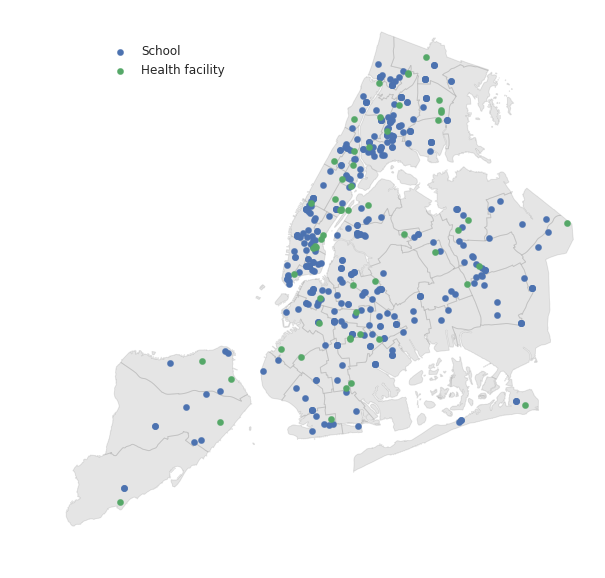

In [52]:
fig, ax = plt.subplots(figsize  = (10, 10))

nyc_puma_geo.plot(ax=ax, edgecolor='grey', lw=1, color='grey', alpha=0.2)

ax.axis('off')

nyc_schools_geo.plot(ax=ax, markersize=40, label='School')
nyc_facilities_geo.plot(ax=ax, markersize=40, label='Health facility', legend=True)

ax.legend()

leg = ax.get_legend()
leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))

plt.show()

**Figure 5: Map of schools and health facilities locations in NYC.** Only schools with SAT scores data for 2012 that are also found in the Safety Report 2010-2016 are shown. The geographical divisions correpond to PUMAs, and the facilities data comes from the SPARCS dataset. We can see that there are some PUMAs without any health facilities. A number of PUMAs have a low number of schools and/or facilities, which might skew the data when aggregating.

#### 5.2 join hospital facilities and PUMA data (3 points)
join the PUMA data with the medical facilities and school data. The resulting dataframe should have :

* a puma number (which you will use to merge with the SAT and crime data)
* the asthmaRatio: ratio of asthma related discharges per puma, averaged by PUMA
* the drugnsRatio: ratio of asthma related discharges per puma, averaged by PUMA

This is a spatial join (hints)

In [53]:
nyc_puma_geo.shape

(55, 4)

In [54]:
#Transform to flat coordinate system for spatial join
nyc_puma_geo = nyc_puma_geo.to_crs(epsg=2263)
nyc_facilities_geo = nyc_facilities_geo.to_crs(epsg=2263)
nyc_schools_geo = nyc_schools_geo.to_crs(epsg=2263)

In [55]:
#Spatial join: PUMAs + Facilities
nyc_facilities_puma = gpd.sjoin(nyc_puma_geo, nyc_facilities_geo)
nyc_facilities_puma.head()

,puma,shape_area,shape_leng,geometry,index_right,facility_id,facility_latitude,facility_longitude,Facility ID,asthma_ratio,drugs_ratio,lonlat
1,3702,1.889860e+08,106050.002302,"POLYGON ((1027331.841796877 256069.2766112776,...",7,1168,40.894569,-73.861420,1168.0,0.036503,0.063314,"(-73.86142, 40.894569)"
3,3704,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972045382,...",6,1165,40.857388,-73.846741,1165.0,0.053588,0.061033,"(-73.846741, 40.857388)"
3,3704,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972045382,...",54,3058,40.849575,-73.845055,3058.0,0.020517,0.003506,"(-73.845055, 40.849575)"
3,3704,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972045382,...",4,1175,40.847294,-73.844658,1175.0,0.008216,0.000000,"(-73.844658, 40.847294)"
5,4016,1.207135e+08,109477.751817,"POLYGON ((999782.7833862281 162246.8424071733,...",15,1293,40.613419,-73.948967,1293.0,0.029730,0.007400,"(-73.948967, 40.613419)"


In [56]:
#Group by puma, and get average of asthma_ratio and drugs_ratio
nyc_facilities_puma = nyc_facilities_puma.groupby('puma', as_index=False)[['asthma_ratio','drugs_ratio']].mean()
nyc_facilities_puma.head()

,puma,asthma_ratio,drugs_ratio
0,3702,0.036503,0.063314
1,3704,0.027440,0.021513
2,3705,0.022103,0.344390
3,3706,0.038256,0.013680
4,3707,0.054454,0.013583


In [57]:
nyc_facilities_puma.shape

(38, 3)

**Note:** Only 38 PUMAs have at least 1 facility

#### 5.3 join school data and puma (3 points)
The resulting dataframe should have :

* a puma number (which you can throw away, but you should check that it is unique in the dataframe)
* the SATmath and SATall score, averaged by PUMA
* 10 crime related features, each averaged by PUMA

In [58]:
#Spatial join: PUMAs + Schools
nyc_schools_puma = gpd.sjoin(nyc_puma_geo, nyc_schools_geo)
nyc_schools_puma.head()

,puma,shape_area,shape_leng,geometry,index_right,DBN,Latitude,Longitude,AvgOfMajor N,AvgOfNoCrim N,...,AvgOfVio N,Major N,NoCrim N,Oth N,Prop N,Vio N,Nstudents,SATmath,SATall,lonlat
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",198,10X549,40.870293,-73.898309,2.65,27.823333,...,5.413333,1.666667,38.666667,8.666667,1.0,7.333333,55.0,379.0,371.666667,"(-73.898309, 40.870293)"
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",193,10X442,40.870293,-73.898309,2.65,27.823333,...,5.413333,1.666667,38.666667,8.666667,1.0,7.333333,52.0,420.0,423.333333,"(-73.898309, 40.870293)"
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",187,10X433,40.870293,-73.898309,2.65,27.823333,...,5.413333,1.666667,38.666667,8.666667,1.0,7.333333,57.0,371.0,368.666667,"(-73.898309, 40.870293)"
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",183,10X342,40.870293,-73.898309,2.65,27.823333,...,5.413333,1.666667,38.666667,8.666667,1.0,7.333333,49.0,333.0,311.333333,"(-73.898309, 40.870293)"
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",180,10X268,40.870293,-73.898309,2.65,27.823333,...,5.413333,1.666667,38.666667,8.666667,1.0,7.333333,52.0,356.0,320.666667,"(-73.898309, 40.870293)"


In [59]:
#Group by puma, and get average of all data
data_columns = list(nyc_schools_puma.columns[8:-4]) + list(nyc_schools_puma.columns[-3:-1])

nyc_schools_puma_copy = nyc_schools_puma.copy()
nyc_schools_puma = nyc_schools_puma.groupby('puma', as_index=False)[data_columns].agg('mean')
nyc_schools_puma.head()

,puma,AvgOfMajor N,AvgOfNoCrim N,AvgOfOth N,AvgOfProp N,AvgOfVio N,Major N,NoCrim N,Oth N,Prop N,Vio N,SATmath,SATall
0,3701,1.806667,17.917273,7.334848,4.001515,3.632424,1.333333,25.787879,6.424242,1.484848,4.696970,443.363636,430.363636
1,3702,2.301111,23.851111,9.136667,5.245556,4.280000,3.444444,46.888889,17.444444,7.111111,9.444444,378.555556,374.740741
2,3703,2.173333,18.976667,8.892667,5.808667,3.793333,3.133333,30.933333,12.333333,7.466667,6.866667,394.400000,391.400000
3,3704,2.350000,24.688889,9.543333,5.035556,4.500556,1.333333,17.388889,8.166667,3.611111,4.444444,412.666667,404.611111
4,3705,1.116049,10.171049,4.405988,2.607346,2.082716,1.345679,14.462963,6.820988,3.759259,3.104938,378.222222,373.629630


**Note:** I should have done the weighted average direcly in the previous cell but I didn't know how to, so I'm fixing it here column by column, weighting by number of students.

In [60]:
#Fix values to be weigthed by number of students
for col in data_columns:
    nyc_schools_puma[col] = nyc_schools_puma_copy.groupby('puma', as_index=False).apply(
        lambda x: np.average(x[col].values, weights=x['Nstudents']))

nyc_schools_puma.head()

,puma,AvgOfMajor N,AvgOfNoCrim N,AvgOfOth N,AvgOfProp N,AvgOfVio N,Major N,NoCrim N,Oth N,Prop N,Vio N,SATmath,SATall
0,3701,1.791659,17.409006,7.849073,4.439885,3.549722,1.577972,24.973646,6.488550,2.032534,4.117594,533.082334,514.588150
1,3702,2.327070,24.156141,9.239810,5.302153,4.329388,3.472171,47.391437,17.544954,7.170031,9.513761,379.027523,373.798165
2,3703,2.184710,19.207758,8.984819,5.882047,3.794755,3.119112,32.042572,12.617754,7.736866,6.880888,416.338315,400.244565
3,3704,2.511786,26.518816,10.226020,5.383166,4.789993,1.403050,18.509804,8.135076,3.577342,4.488017,411.054466,402.906318
4,3705,1.056572,9.542205,4.162905,2.476264,1.962623,1.255497,13.529464,6.800792,3.658971,2.970317,383.781662,378.034960


In [61]:
nyc_schools_puma.shape

(53, 13)

**Note:** 2 PUMAs don't have any schools (or more likely any schools with SAT and crime data)

In [62]:
alldata = pd.merge(nyc_schools_puma, nyc_facilities_puma, on='puma', how='outer')
alldata.head()

,puma,AvgOfMajor N,AvgOfNoCrim N,AvgOfOth N,AvgOfProp N,AvgOfVio N,Major N,NoCrim N,Oth N,Prop N,Vio N,SATmath,SATall,asthma_ratio,drugs_ratio
0,3701,1.791659,17.409006,7.849073,4.439885,3.549722,1.577972,24.973646,6.488550,2.032534,4.117594,533.082334,514.588150,NaN,NaN
1,3702,2.327070,24.156141,9.239810,5.302153,4.329388,3.472171,47.391437,17.544954,7.170031,9.513761,379.027523,373.798165,0.036503,0.063314
2,3703,2.184710,19.207758,8.984819,5.882047,3.794755,3.119112,32.042572,12.617754,7.736866,6.880888,416.338315,400.244565,NaN,NaN
3,3704,2.511786,26.518816,10.226020,5.383166,4.789993,1.403050,18.509804,8.135076,3.577342,4.488017,411.054466,402.906318,0.027440,0.021513
4,3705,1.056572,9.542205,4.162905,2.476264,1.962623,1.255497,13.529464,6.800792,3.658971,2.970317,383.781662,378.034960,0.022103,0.344390


In [63]:
alldata.shape

(54, 15)

In [64]:
alldata.isnull().sum()

puma              0
AvgOfMajor N      1
AvgOfNoCrim N     1
AvgOfOth N        1
AvgOfProp N       1
AvgOfVio N        1
Major N           1
NoCrim N          1
Oth N             1
Prop N            1
Vio N             1
SATmath           1
SATall            1
asthma_ratio     16
drugs_ratio      16
dtype: int64

In [65]:
#Join all data with PUMAs geo dataframe
alldata_geo = nyc_puma_geo.merge(alldata, on='puma', how='left')
alldata_geo.head()

,puma,shape_area,shape_leng,geometry,AvgOfMajor N,AvgOfNoCrim N,AvgOfOth N,AvgOfProp N,AvgOfVio N,Major N,NoCrim N,Oth N,Prop N,Vio N,SATmath,SATall,asthma_ratio,drugs_ratio
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",1.791659,17.409006,7.849073,4.439885,3.549722,1.577972,24.973646,6.488550,2.032534,4.117594,533.082334,514.588150,NaN,NaN
1,3702,1.889860e+08,106050.002302,"POLYGON ((1027331.841796877 256069.2766112776,...",2.327070,24.156141,9.239810,5.302153,4.329388,3.472171,47.391437,17.544954,7.170031,9.513761,379.027523,373.798165,0.036503,0.063314
2,3703,2.670137e+08,304071.257466,(POLYGON ((1042822.450195312 243439.8142089319...,2.184710,19.207758,8.984819,5.882047,3.794755,3.119112,32.042572,12.617754,7.736866,6.880888,416.338315,400.244565,NaN,NaN
3,3704,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972045382,...",2.511786,26.518816,10.226020,5.383166,4.789993,1.403050,18.509804,8.135076,3.577342,4.488017,411.054466,402.906318,0.027440,0.021513
4,4015,8.105438e+07,50007.415493,"POLYGON ((997086.4570312516 171933.9880370507,...",1.719370,13.669312,8.548216,5.656222,2.827614,2.156243,7.166559,7.802063,6.781216,2.197937,508.219213,484.437782,NaN,NaN


In [66]:
alldata_geo.isnull().sum()

puma              0
shape_area        0
shape_leng        0
geometry          0
AvgOfMajor N      2
AvgOfNoCrim N     2
AvgOfOth N        2
AvgOfProp N       2
AvgOfVio N        2
Major N           2
NoCrim N          2
Oth N             2
Prop N            2
Vio N             2
SATmath           2
SATall            2
asthma_ratio     17
drugs_ratio      17
dtype: int64

In [67]:
alldata_geo.shape

(55, 18)

**Note:** We have 1 PUMA with no school crime data, 16 PUMAs with no health data, and 1 PUMA without both.

### Extra Credit : add income data
income data comes from the 2012 5 year ACS survey which can be accessed at the PUMA level

**Note:** I will use the variable B06011_001E, which is 'Estimate: Median income in the past 12 months, Total'

In [73]:
#Download ACS 2012 5 year NY files
url = 'https://api.census.gov/data/2012/acs/acs5?get=B06011_001E&for=public%20use%20microdata%20area:*&in=state:36&key={}'.format(
    CensusKey)
resp = requests.request('GET', url).content
puma_income = pd.read_csv(stringIO.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
puma_income.head()

,B06011_001E,state,public use microdata area,Unnamed: 3
0,40531,36,3101,NaN
1,36442,36,3102,NaN
2,50869,36,3103,NaN
3,36439,36,3104,NaN
4,47155,36,3105,NaN


In [74]:
puma_income.drop(['state', 'Unnamed: 3'], axis=1, inplace=True)
puma_income.rename(columns={'public use microdata area':'puma', 'B06011_001E':'median_income'}, inplace=True)
puma_income.head()

,median_income,puma
0,40531,3101
1,36442,3102
2,50869,3103
3,36439,3104
4,47155,3105


In [75]:
alldata_geo.puma = alldata_geo.puma.astype(int)
alldata_geo = alldata_geo.merge(puma_income, on='puma')
alldata_geo.head()

,puma,shape_area,shape_leng,geometry,AvgOfMajor N,AvgOfNoCrim N,AvgOfOth N,AvgOfProp N,AvgOfVio N,Major N,NoCrim N,Oth N,Prop N,Vio N,SATmath,SATall,asthma_ratio,drugs_ratio,median_income
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",1.791659,17.409006,7.849073,4.439885,3.549722,1.577972,24.973646,6.488550,2.032534,4.117594,533.082334,514.588150,NaN,NaN,30509
1,3702,1.889860e+08,106050.002302,"POLYGON ((1027331.841796877 256069.2766112776,...",2.327070,24.156141,9.239810,5.302153,4.329388,3.472171,47.391437,17.544954,7.170031,9.513761,379.027523,373.798165,0.036503,0.063314,26649
2,3703,2.670137e+08,304071.257466,(POLYGON ((1042822.450195312 243439.8142089319...,2.184710,19.207758,8.984819,5.882047,3.794755,3.119112,32.042572,12.617754,7.736866,6.880888,416.338315,400.244565,NaN,NaN,32103
3,3704,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972045382,...",2.511786,26.518816,10.226020,5.383166,4.789993,1.403050,18.509804,8.135076,3.577342,4.488017,411.054466,402.906318,0.027440,0.021513,25892
4,4015,8.105438e+07,50007.415493,"POLYGON ((997086.4570312516 171933.9880370507,...",1.719370,13.669312,8.548216,5.656222,2.827614,2.156243,7.166559,7.802063,6.781216,2.197937,508.219213,484.437782,NaN,NaN,24776


In [76]:
alldata_geo.shape

(55, 19)

## PART II Visual and Exploratory analysis and Modeling
### 6 checking collinearity and covariance of the data (10 points)
remember to write comments for each plot!

Use 3 crime features and 2 medial features: asthmaRatio, drugsRatio and Major N, AvgOfNoCrim N, AvgOfMajor N. If you got income in the extra credit above also plot against income

#### 6.1 plot SAT features against each other and assess collinearity (4 points)

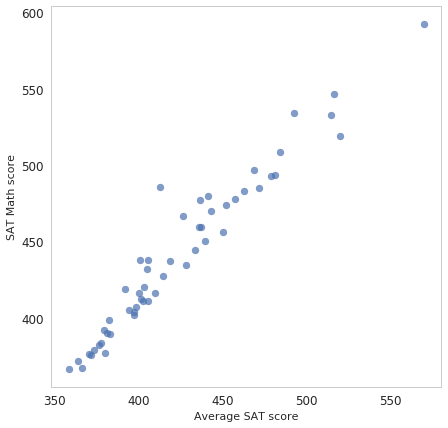

In [77]:
#Plot
fig, (ax1) = pl.subplots(nrows=1, ncols=1, figsize=(7,7))

#SAT Math score
#Number of major crimes
ax1.set_ylabel('SAT Math score', fontsize=11)
ax1.set_xlabel('Average SAT score', fontsize=11)

ax1.scatter(alldata_geo['SATall'], alldata_geo['SATmath'], alpha=0.7)
ax1.grid(False)

pl.show()

**Figure 6: Scatter plot of SAT features agains each other.** There is a high positive correlation between the SAT math score and the SAT avg score, which makes a lot of sense. As this two features are very collinear, making a model for one should be almost the same as making the same model for the other one. Therefore, we can use one of both for the modeling part without any problem. I will continue ahead using only the SAT avg score feature.

#### 6.2 plot the SAT feature by PUMA against 3 of the crime features (3 points)

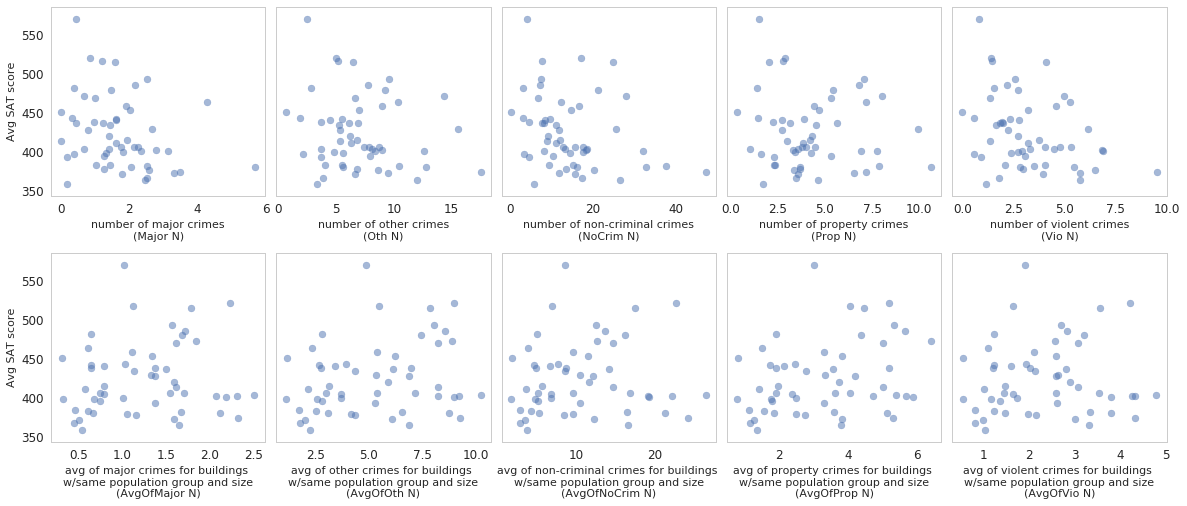

In [78]:
#Inspect the distribution of crimes
fig, axes = pl.subplots(nrows=2, ncols=5, figsize=(20,8), sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0.05)

for i, col in enumerate(crime_columns[:5]):
    axes[0][i].scatter(alldata_geo[col], alldata_geo['SATall'], alpha=0.5)
    axes[0][i].set_xlabel('{}\n({})'.format(data_dictionary[col],col), fontsize=11)
    axes[0][i].grid(False)

axes[0][0].set_ylabel('Avg SAT score', fontsize=11)

for i, col in enumerate(crime_columns[5:]):
    axes[1][i].scatter(alldata_geo[col], alldata_geo['SATall'], alpha=0.5)
    axes[1][i].set_xlabel('{}\n({})'.format(data_dictionary[col].replace('w/','\nw/'),col), fontsize=11)
    axes[1][i].grid(False)

axes[1][0].set_ylabel('Avg SAT score', fontsize=11)

pl.show()

**Figure 7: Average SAT score against each crime statistic by PUMA.** The first row of plots shows the crime statistics with the actual crime report number per school, averaged to the PUMA level. We can see that those statistics have a slight negative correlation with the SAT score, or at least the data points with high crime reports have a lower maximum SAT score (less variance and lower mean score). For the second row, there is no clear correlation and it seems to be mostly random. This makes sense as this data comes from the average of schools with same population group and size across PUMAs, and then we averaged at the PUMA level. 

#### 6.3 plot the SAT feature against medical data (3 points)

In [79]:
#Adding the rest of the variables to the dictionary
data_dictionary['asthma_ratio'] = 'Avg ratio of asthma related discharges'
data_dictionary['drugs_ratio'] = 'Avg ratio of drug related discharges'
data_dictionary['median_income'] = 'Median income'

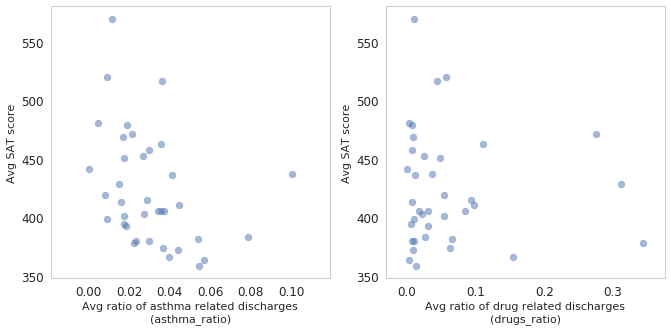

In [80]:
#Plot
fig, (ax1, ax2) = pl.subplots(nrows=1, ncols=2, figsize=(11,5))

#SATall feature vs Number of major crimes
ax1.set_ylabel('Avg SAT score', fontsize=11)
ax1.set_xlabel('{}\n({})'.format(data_dictionary['asthma_ratio'].replace('w/','\nw/'),'asthma_ratio'), fontsize=11)

ax1.scatter(alldata_geo['asthma_ratio'], alldata_geo['SATall'], alpha=0.5)
ax1.grid(False)

#Number of major crimes
ax2.set_ylabel('Avg SAT score', fontsize=11)
ax2.set_xlabel('{}\n({})'.format(data_dictionary['drugs_ratio'].replace('w/','\nw/'),'drugs_ratio'), fontsize=11)

ax2.scatter(alldata_geo['drugs_ratio'], alldata_geo['SATall'], alpha=0.5)
ax2.grid(False)


pl.show()

**Figure 8: Average SAT score against each medical statistic by PUMA.** We can see that the medical statistics have a slight negative correlation with the SAT score at the PUMA level, and it looks stronger for the asthma ratio. 

#### 6.4 plot the SAT feature against median income

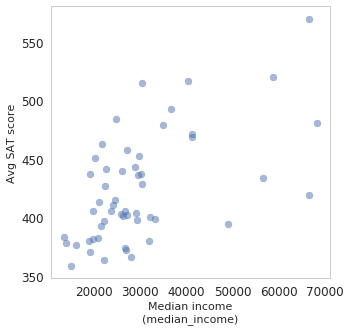

In [81]:
#Plot
fig, ax1 = pl.subplots(nrows=1, ncols=1, figsize=(5,5))

#SATall feature vs Number of major crimes
ax1.set_ylabel('Avg SAT score', fontsize=11)
ax1.set_xlabel('{}\n({})'.format(data_dictionary['median_income'].replace('w/','\nw/'),'median_income'), fontsize=11)

ax1.scatter(alldata_geo['median_income'], alldata_geo['SATall'], alpha=0.5)
ax1.grid(False)

pl.show()

**Figure 9: Average SAT score against median income by PUMA.** We can see that there is a positive correlation between median income and the SAT score at the PUMA level.

#### Extra Credit: plot a covariance matrix of all features
describe and interpret its structure

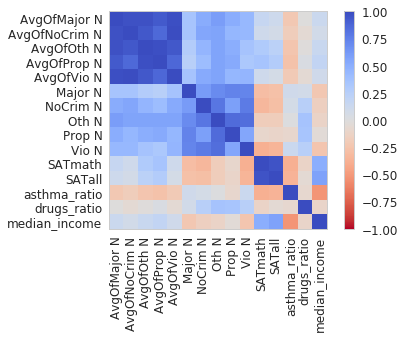

In [82]:
#Skip non-data rows
corr_matrix = alldata_geo.iloc[:,4:].corr()
features = alldata_geo.columns[4:]

ax = pl.figure().add_subplot(111)
cax = ax.imshow(corr_matrix, cmap='coolwarm_r', vmin=-1, vmax=1)
pl.colorbar(cax)
ax.set_xticks(range(len(features)))
ax.set_xticklabels(features, rotation=90)
ax.set_yticks(range(len(features)))
ax.set_yticklabels(features);
ax.grid('off')

**Figure 10: Covariance matrix of all features.** The range of colors in the matrix goes from red for perfectly negative correlation to blue for perfectly positive correlation, and white is no correlation. The diagonal is blue as it shows the correlation between each feature and itself. All the crime features have high positive correlation between them, specially the averaged ones. This is an indicator of multicollinearity that will impact our models.

Also, as we saw above, average SAT and math SAT have almost perfect positive correlation. The crime report numbers statistic (Major N, NoCrim N, Oth N, Prop N, and Vio N) have a negative correlation with SAT scores, and the averaged ones have almost no correlation with SAT scores. Asthma ratio has a stronger negative correlation than drugs ratio with SAT scores, and median income has a positivive correlation with SAT scores. This confirms what we saw before in the scatter plots.

There is some correlation between crime statistics, medical statistics, and median income, but weak. 

### 7 Mapping (10 points)
plot choropleths (maps where each area is colorcoded by the value of a variable) of

* the SAT features,
* the 3 chosen school crime features
* the two medical discharge fieatures
* the income if you have it from the extra credit
remember your visualization lecture!

plot it in a way that allows comparison (hint)

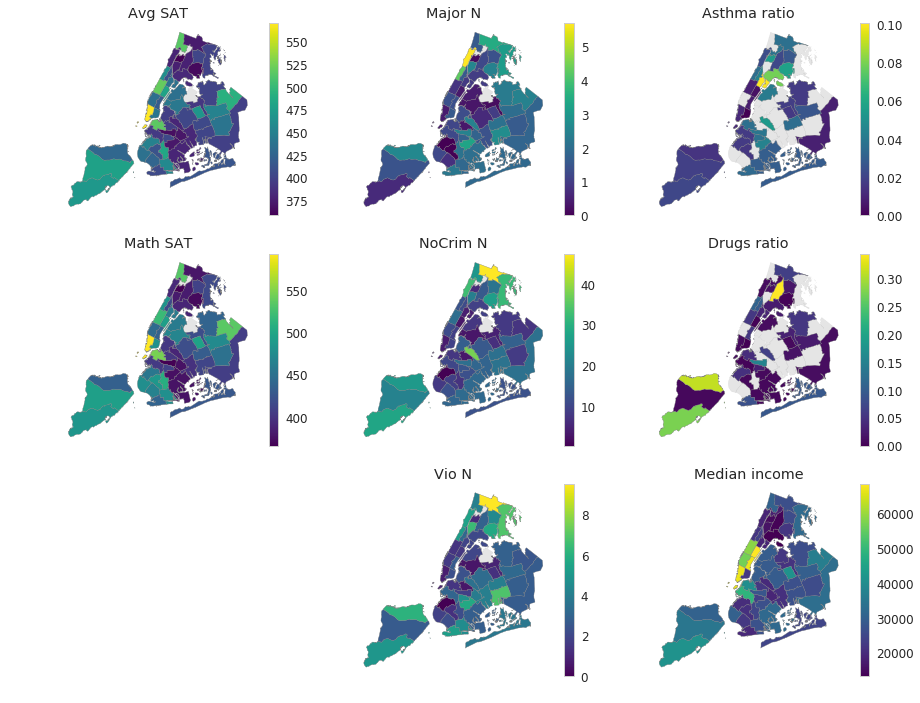

In [83]:
fig = pl.figure(figsize = (15,12))

ax1 = fig.add_subplot(331)
nyc_puma_geo.plot(ax=ax1, color='grey', edgecolors='grey', alpha=0.2)
alldata_geo.loc[~alldata_geo.SATall.isnull(),:].plot(
    column='SATall', ax=ax1, cmap='viridis', edgecolors='grey', legend=True)
ax1.axis('off')
ax1.set_title('Avg SAT')

ax2 = fig.add_subplot(334)
nyc_puma_geo.plot(ax=ax2, color='grey', edgecolors='grey', alpha=0.2)
alldata_geo.loc[~alldata_geo.SATmath.isnull(),:].plot(
    column='SATmath', ax=ax2, cmap='viridis', edgecolors='grey', legend=True)
ax2.axis('off')
ax2.set_title('Math SAT')

ax3 = fig.add_subplot(332)
nyc_puma_geo.plot(ax=ax3, color='grey', edgecolors='grey', alpha=0.2)
alldata_geo.loc[~alldata_geo['Major N'].isnull(),:].plot(
    column='Major N', ax=ax3, cmap='viridis', edgecolors='grey', legend=True)
ax3.axis('off')
ax3.set_title('Major N')

ax4 = fig.add_subplot(335)
nyc_puma_geo.plot(ax=ax4, color='grey', edgecolors='grey', alpha=0.2)
alldata_geo.loc[~alldata_geo['NoCrim N'].isnull(),:].plot(
    column='NoCrim N', ax=ax4, cmap='viridis', edgecolors='grey', legend=True)
ax4.axis('off')
ax4.set_title('NoCrim N')

ax5 = fig.add_subplot(338)
nyc_puma_geo.plot(ax=ax5, color='grey', edgecolors='grey', alpha=0.2)
alldata_geo.loc[~alldata_geo['Vio N'].isnull(),:].plot(
    column='Vio N', ax=ax5, cmap='viridis', edgecolors='grey', legend=True)
ax5.axis('off')
ax5.set_title('Vio N')

ax6 = fig.add_subplot(333)
nyc_puma_geo.plot(ax=ax6, color='grey', edgecolors='grey', alpha=0.2)
alldata_geo.loc[~alldata_geo['asthma_ratio'].isnull(),:].plot(
    column='asthma_ratio', ax=ax6, cmap='viridis', edgecolors='grey', legend=True)
ax6.axis('off')
ax6.set_title('Asthma ratio')

ax7 = fig.add_subplot(336)
nyc_puma_geo.plot(ax=ax7, color='grey', edgecolors='grey', alpha=0.2)
alldata_geo.loc[~alldata_geo['drugs_ratio'].isnull(),:].plot(
    column='drugs_ratio', ax=ax7, cmap='viridis', edgecolors='grey', legend=True)
ax7.axis('off')
ax7.set_title('Drugs ratio')

ax8 = fig.add_subplot(339)
nyc_puma_geo.plot(ax=ax8, color='grey', edgecolors='grey', alpha=0.2)
alldata_geo.loc[~alldata_geo['median_income'].isnull(),:].plot(
    column='median_income', ax=ax8, cmap='viridis', edgecolors='grey', legend=True)
ax8.axis('off')
ax8.set_title('Median income')

pl.show()

**Figure 11: Maps of NYC for different analyzed features at the PUMA level.** Some PUMAs are displayed in grey in some of the maps, when we don't have data for that specific feature for that PUMA. The selected crime features are the ones that showed the highest negative correlation with the SAT features. We can see that there are some outliers in each map, which could be because of our agreggation method where some PUMAs might have too few observations.

### 8 Start with linear modeling (10 points)
create the models and discuss the results including pros and cons of the model choice (hint)

#### 8.1 create a multivariate-linear model using only the crime in school features, but using all 10 of them, predicting the chosen SAT feature (5 points)
for example with

statsmodels.formula()
hint

print and discuss the model summary

In [84]:
#First need to drop rows with Nan values
alldata_clean = alldata_geo.dropna()
alldata_clean.shape

(37, 19)

**Note:** These are the 37 PUMAs that have both crime in school features and facilities discharge data

In [85]:
#Replace spaces in column names with underscore
alldata_clean.columns = [s.replace(' ', '_') for s in alldata_clean.columns]
features = [s.replace(' ', '_') for s in alldata_clean.columns][4:]
alldata_clean.head()

,puma,shape_area,shape_leng,geometry,AvgOfMajor_N,AvgOfNoCrim_N,AvgOfOth_N,AvgOfProp_N,AvgOfVio_N,Major_N,NoCrim_N,Oth_N,Prop_N,Vio_N,SATmath,SATall,asthma_ratio,drugs_ratio,median_income
1,3702,1.889860e+08,106050.002302,"POLYGON ((1027331.841796877 256069.2766112776,...",2.327070,24.156141,9.239810,5.302153,4.329388,3.472171,47.391437,17.544954,7.170031,9.513761,379.027523,373.798165,0.036503,0.063314,26649
3,3704,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972045382,...",2.511786,26.518816,10.226020,5.383166,4.789993,1.403050,18.509804,8.135076,3.577342,4.488017,411.054466,402.906318,0.027440,0.021513,25892
5,4016,1.207135e+08,109477.751817,"POLYGON ((999782.7833862281 162246.8424071733,...",1.112698,9.505084,5.404636,3.294018,2.110359,1.892070,16.575847,8.977295,4.420533,4.604146,477.651530,457.687726,0.029730,0.007400,27204
6,3705,1.224951e+08,68657.316149,"POLYGON ((1019225.58178711 245263.8524169383, ...",1.056572,9.542205,4.162905,2.476264,1.962623,1.255497,13.529464,6.800792,3.658971,2.970317,383.781662,378.034960,0.022103,0.344390,14019
8,3707,4.228113e+07,37347.925798,"POLYGON ((1012642.970825195 252164.6224364594,...",0.536667,3.630000,2.236667,1.346667,1.033333,0.174041,5.870206,3.377581,1.710914,1.159292,366.150442,358.595870,0.054454,0.013583,14906


In [86]:
OLS1 = smf.ols(formula = "SATall ~ Major_N + Oth_N + NoCrim_N + Prop_N + Vio_N + AvgOfMajor_N + AvgOfOth_N + " + \
               "AvgOfNoCrim_N + AvgOfProp_N + AvgOfVio_N", data=alldata_clean).fit()
OLS1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     1.766
Date:                Sun, 16 Dec 2018   Prob (F-statistic):              0.118
Time:                        15:12:52   Log-Likelihood:                -186.15
No. Observations:                  37   AIC:                             394.3
Df Residuals:                      26   BIC:                             412.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       438.9649     27.326     16.064      0.000       382.795   495.134
Major_N          12.8746     16.706      0.771      0.448       -21.466    47.215
Oth_N            11.8659     12.940      0.917      0.368       -14.733    38.465
NoCrim_N         -1.6580      1.600     -1.036      0.310        -4.948     1.632
Prop_N          -13.3134     13.422     -0.992      0.330       -40.902    14.275
Vio_N           -17.3985     16.295     -1.068      0.295       -50.893    16.096
AvgOfMajor_N   -139.3109    161.670     -0.862      0.397      -471.629   193.007
AvgOfOth_N      -28.8899     58.435     -0.494      0.625      -149.004    91.224
AvgOfNoCrim_N     8.7640     10.626      0.825      0.417       -13.077    30.605
AvgOfProp_N      81.0580     80.926      1.002      0.326       -85.288   247.404
AvgOfVio_N       -5.4272     74.579     -0.073      0.943      -158.726   147.871
==============================================================================
Omnibus:                        4.772   Durbin-Watson:                   1.491
Prob(Omnibus):                  0.092   Jarque-Bera (JB):                3.359
Skew:                           0.589   Prob(JB):                        0.186
Kurtosis:                       3.890   Cond. No.                         642.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Discussion:** The $R^2$ is 0.405 but the $Adj. R^2$ is 0.17. The second one punishes for the inclusion of more variables, and in this case the difference between both measures is considerable. If we look at the coefficients, none of them is significant at the 0.05 level (not even at the 0.1 level). Also, some of the coeficcients are positive which doesn't make much sense as we would expect that for higher crime rate lower SAT scores. This could be because of the high multicollinearity between the crime variables, and we should maybe use only one of them or a combination like the sum of reports of all crime types.

#### 8.2 add drugs and asthma discharge data and create a new multilinear model (5 points)

In [87]:
OLS2 = smf.ols(formula = "SATall ~ Major_N + Oth_N + NoCrim_N + Prop_N + Vio_N + AvgOfMajor_N + AvgOfOth_N + " + \
               "AvgOfNoCrim_N + AvgOfProp_N + AvgOfVio_N + asthma_ratio + drugs_ratio", data=alldata_clean).fit()
OLS2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     1.783
Date:                Sun, 16 Dec 2018   Prob (F-statistic):              0.110
Time:                        15:12:52   Log-Likelihood:                -183.95
No. Observations:                  37   AIC:                             393.9
Df Residuals:                      24   BIC:                             414.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       468.1589     32.286     14.500      0.000       401.524   534.794
Major_N          14.5814     17.283      0.844      0.407       -21.089    50.251
Oth_N            13.4601     12.724      1.058      0.301       -12.801    39.721
NoCrim_N         -1.5675      1.572     -0.997      0.329        -4.812     1.677
Prop_N          -16.0267     13.636     -1.175      0.251       -44.170    12.117
Vio_N           -17.0083     16.043     -1.060      0.300       -50.120    16.103
AvgOfMajor_N   -138.8395    158.552     -0.876      0.390      -466.074   188.395
AvgOfOth_N      -29.6113     58.068     -0.510      0.615      -149.458    90.235
AvgOfNoCrim_N     9.8117     10.600      0.926      0.364       -12.065    31.689
AvgOfProp_N      79.2356     79.947      0.991      0.332       -85.768   244.239
AvgOfVio_N      -11.8930     73.435     -0.162      0.873      -163.455   139.669
asthma_ratio   -680.0824    390.512     -1.742      0.094     -1486.060   125.895
drugs_ratio     -14.4201    107.108     -0.135      0.894      -235.481   206.640
==============================================================================
Omnibus:                        3.049   Durbin-Watson:                   1.760
Prob(Omnibus):                  0.218   Jarque-Bera (JB):                1.876
Skew:                           0.492   Prob(JB):                        0.391
Kurtosis:                       3.499   Cond. No.                     1.34e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Discussion:** The $R^2$ is 0.471 and the $Adj. R^2$ is 0.207. When comparing the $Adj. R^2$ with the previous one we can see that we have an improvement considering the punishmet for adding new variables. Again, no coefficient is significant at the 0.05 level. The most significant feature in this case is the asthma_ratio at 0.094 p-value. Both the asthma_ratio and drugs_ratio have a negative coefficient as we would expect.

#### Extra credit: if you have income add income data and create a new multilinear model

In [88]:
OLS3 = smf.ols(formula = "SATall ~ Major_N + Oth_N + NoCrim_N + Prop_N + Vio_N + AvgOfMajor_N + AvgOfOth_N + " + \
               "AvgOfNoCrim_N + AvgOfProp_N + AvgOfVio_N + asthma_ratio + drugs_ratio + median_income", data=alldata_clean).fit()
OLS3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     3.160
Date:                Sun, 16 Dec 2018   Prob (F-statistic):            0.00776
Time:                        15:12:52   Log-Likelihood:                -176.79
No. Observations:                  37   AIC:                             381.6
Df Residuals:                      23   BIC:                             404.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       390.0038     36.061     10.815      0.000       315.406   464.601
Major_N          19.1345     14.613      1.309      0.203       -11.095    49.364
Oth_N            13.9166     10.711      1.299      0.207        -8.241    36.074
NoCrim_N         -1.8322      1.326     -1.382      0.180        -4.575     0.910
Prop_N          -15.5792     11.479     -1.357      0.188       -39.325     8.167
Vio_N           -17.1389     13.504     -1.269      0.217       -45.075    10.797
AvgOfMajor_N   -126.3072    133.515     -0.946      0.354      -402.504   149.889
AvgOfOth_N       -1.3822     49.623     -0.028      0.978      -104.035   101.270
AvgOfNoCrim_N     7.9586      8.940      0.890      0.383       -10.535    26.453
AvgOfProp_N      39.4117     68.371      0.576      0.570      -102.024   180.847
AvgOfVio_N      -21.8796     61.888     -0.354      0.727      -149.904   106.145
asthma_ratio    -68.9518    377.363     -0.183      0.857      -849.587   711.684
drugs_ratio      47.0736     92.067      0.511      0.614      -143.381   237.528
median_income     0.0018      0.001      3.297      0.003         0.001     0.003
==============================================================================
Omnibus:                        4.336   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.114   Jarque-Bera (JB):                1.893
Skew:                          -0.185   Prob(JB):                        0.388
Kurtosis:                       1.956   Cond. No.                     2.13e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Discussion:** The $R^2$ is 0.641 and the $Adj. R^2$ is 0.438. When comparing the $Adj. R^2$ with the previous one we can see that we have a significant improvement considering the punishmet for adding new variables. In this model, we finally hava a coefficient that is significant at the 0.05 level: the median income. The coefficient is positive, so higher median income indicates higher SAT score, which makes sense.

### 9 Compare the linear models (10 points):
which is the right level of complexity? this should be a proper statistical test that returns a p-value for the null hypothesis that one model is better than the other. (hint)

In [89]:
lr_stat2, p_value2, dof_diff2 = OLS2.compare_lr_test(OLS1)
evalNullHypothesis(p_value2,
                   lr_stat2,
                   test='Likelihood Ratio',
                   hypothesis='the model with only crime in school features\nfits the data better than ' + \
                   'the model that also incorporates drugs and asthma discharge data')

The Null Hypothesis that the model with only crime in school features
fits the data better than the model that also incorporates drugs and asthma discharge data
cannot be rejected (p<0.05)
with a Likelihood Ratio statistics of 4.41 and a p-value of 0.11049482224428715


**Discussion:** When comparing the first and second models, the result of the Likelihood Ratio test with a 0.05 significance level indicates that the more simple model is better, the one with only the crime features.

In [90]:
lr_stat2, p_value2, dof_diff2 = OLS3.compare_lr_test(OLS1)
evalNullHypothesis(p_value2,
                   lr_stat2,
                   test='Likelihood Ratio',
                   hypothesis='the model with only crime in school features\nfits the data better than ' + \
                   'the model that incorporates medical data and median income')

The Null Hypothesis that the model with only crime in school features
fits the data better than the model that incorporates medical data and median income
can be rejected at alpha = 0.05
with a Likelihood Ratio statistics of 18.73 and a p-value of 0.00031109599176078347


**Discussion:** When comparing the first and third models, the result of the Likelihood Ratio test with a 0.05 significance level indicates that the more complex model is better, the one with all the features including median income.

### Extra credit: if you did the income model, based on this result is there another multilinear model you would like to run?

In [91]:
OLS4 = smf.ols(formula = "SATall ~ Vio_N + asthma_ratio + median_income", data=alldata_clean).fit()
OLS4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     8.817
Date:                Sun, 16 Dec 2018   Prob (F-statistic):           0.000196
Time:                        15:12:52   Log-Likelihood:                -184.85
No. Observations:                  37   AIC:                             377.7
Df Residuals:                      33   BIC:                             384.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       387.5399     27.924     13.879      0.000       330.729   444.351
Vio_N            -5.5556      3.359     -1.654      0.108       -12.389     1.278
asthma_ratio    -98.5918    363.471     -0.271      0.788      -838.079   640.895
median_income     0.0019      0.001      3.581      0.001         0.001     0.003
==============================================================================
Omnibus:                        0.248   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.884   Jarque-Bera (JB):                0.444
Skew:                          -0.044   Prob(JB):                        0.801
Kurtosis:                       2.471   Cond. No.                     1.97e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [92]:
lr_stat2, p_value2, dof_diff2 = OLS3.compare_lr_test(OLS4)
evalNullHypothesis(p_value2,
                   lr_stat2,
                   test='Likelihood Ratio',
                   hypothesis='the model with only one crime statistic per type\nfits the data better than ' + \
                   'the model that incorporates all the features')

The Null Hypothesis that the model with only one crime statistic per type
fits the data better than the model that incorporates all the features
cannot be rejected (p<0.05)
with a Likelihood Ratio statistics of 16.13 and a p-value of 0.09599128253034657


**Discussion:** For this model I chose only one feature per type, taking the one that had the most significant coefficient in each of the other models. This would avoid multicollinearity between the features that we saw in the previous analysis. The $Adj. R^2$ is 0.394, slightly lower than the last model. However, the result of the Likelihood Ratio test with a 0.05 significance level indicates that the more simple model is better, the one with the three selected features.

Still, the median income feature is the only that has a significant coefficient at the 0.05 level. We can also see that now all the feature coefficients have a sign that makes sense according to the theory.

### 10 Random forest regression on school-related data only (10 points)
create, the models, evaluate their performance, assess the feature importance. (hint)

NOTE: do not forget to properly prepare your data for modeling!!

#### 10.1 create a random forest model using only the crime in school data, but using all 10 crime in school features (5 points)
measure the model accuracy, precision, recall and the feature importance #(hints)

In [93]:
#First, scale data over the columns (default)
alldata_scaled = pd.DataFrame(columns=features, data=preprocessing.scale(alldata_clean.loc[:,features]))
alldata_scaled.head()

,AvgOfMajor_N,AvgOfNoCrim_N,AvgOfOth_N,AvgOfProp_N,AvgOfVio_N,Major_N,NoCrim_N,Oth_N,Prop_N,Vio_N,SATmath,SATall,asthma_ratio,drugs_ratio,median_income
0,1.780111,2.019356,1.553109,1.392118,1.760841,1.508633,3.326860,2.798352,1.205163,3.284549,-1.144918,-1.038248,0.313133,0.058386,-0.275534
1,2.088125,2.376619,1.940667,1.446625,2.168588,-0.237999,0.385808,0.221093,-0.376025,0.653618,-0.540778,-0.431913,-0.138621,-0.445099,-0.328485
2,-0.244856,-0.196044,0.045975,0.041022,-0.203540,0.174803,0.188871,0.451767,-0.004926,0.714410,0.715474,0.709207,-0.024463,-0.615087,-0.236713
3,-0.338446,-0.190431,-0.441997,-0.509171,-0.334322,-0.362555,-0.121347,-0.144352,-0.340100,-0.140885,-1.055238,-0.949994,-0.404635,3.443848,-1.158977
4,-1.205389,-1.084422,-1.198964,-1.269177,-1.156970,-1.275458,-0.901298,-1.081931,-1.197464,-1.088940,-1.387824,-1.354918,1.207897,-0.540607,-1.096933


In [94]:
#For reproducibility
np.random.seed(0)

#Define features and target label
X = alldata_scaled.iloc[:,:10]
y = alldata_scaled['SATall']

#Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [95]:
#Fit RFR with train data
rfr = RandomForestRegressor(max_depth=3, n_estimators=100)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [96]:
rfr.score(X_test, y_test)

-1.0249448427161165

**Discussion:** $R^2$ is negative, which indicates that our RF regression model is very bad. According to the score description, a constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0. So this model is arbitrarily worse than that. This could be because of the high multicollinearity between the features.

#### 10.2 measure the feature importance of the features in this model to select the 3 most predictive features (5 points)
You can use the code featureImportancePlotter.py if you want to visualize feature importance

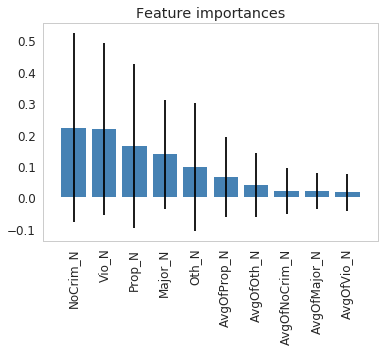

In [97]:
featureImportancePlot(rfr, alldata_scaled.columns[:10])

**Figure 12: Feature importances for the Random Forest regression model using all crime features, with error bars.** From the plot we can see that all the count features are more important than the averaged features. This makes sense as we saw before that the averaged features are not correlated with the SAT scores. It is important to note that the variance in the feature importances is very high, and in all cases the error bar includes zero. This means that all the features could have zero importance, which is in line with the low $R^2$ we have for this model and the results we had before with the linear models.

In [98]:
print('The three most important features are:')
important_features = []
for n, index in enumerate(np.argsort(rfr.feature_importances_)[:-4:-1]):
    important_features.append(alldata_scaled.columns[index])
    print('\t{}. {}'.format(n+1, alldata_scaled.columns[index]))

The three most important features are:
	1. NoCrim_N
	2. Vio_N
	3. Prop_N


### 11 random forest with crime and medical (and income if you have it) features
hints on modeling

#### 11.1 create a random forest model that only uses the 3 most predictive features about school crimes and the health features (and income if you have it from the EC) (3 points)

In [99]:
final_features = important_features + ['asthma_ratio', 'drugs_ratio', 'median_income']
final_features

['NoCrim_N', 'Vio_N', 'Prop_N', 'asthma_ratio', 'drugs_ratio', 'median_income']

In [100]:
#Define features and target label
X = alldata_scaled.loc[:,final_features]
y = alldata_scaled['SATall']

#Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [101]:
#Fit RFR with train data
rfr = RandomForestRegressor(max_depth=3, n_estimators=100)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

#### 11.2 evaluate the performance of the model (3 points)

In [103]:
rfr.score(X_test, y_test)

0.22433607073909001

**Discussion:** $R^2$ is 0.22, which indicates that our RF regression model explains 22 percent of the variance in the target feature. The score is lower than the $Adj. R^2$ of the liner models that included median income information, which could indicate that the linear models where better. A more formal comparison would be needed to assess this.

#### 11.3 discuss the importance of each feature in the model (4 points)

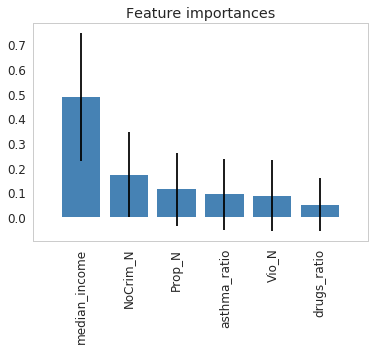

In [104]:
featureImportancePlot(rfr, final_features)

**Figure 13: Feature importances for the final Random Forest regression model, with error bars.** From the plot we can see that the most important feature is the median income, and also it is the only one where the error bar doesn't cover the zero. This is in line with our results in the linear models, where the only significant coefficient was also the one for the median income feature.